In [1]:
# import the necessary packages
import torch
import os
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# base path of the dataset
# DATASET_PATH = os.path.join("dataset", "train")

# define the path to the images and masks dataset
# IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
# MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")

# define the test split
# TEST_SPLIT = 0.15

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

In [3]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 200
BATCH_SIZE = 32

# define the input image dimensions
INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256

# define threshold to filter weak predictions
THRESHOLD = 0.5

# define the path to the base output directory
BASE_OUTPUT = "output"

# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [4]:
subdir = ["benign_image/", "benign_mask/", "malignant_image/",
          "malignant_mask/", "normal_image/", "normal_mask/"]
dataset = ['dataset/','train/', 'test/', 'validation/']

train_test_valid = [[[], [], []], [[], [], []], [[], [], []]]

for i in range(1, len(dataset)):
    for j in range(3):
    # for j in range(2):
        for k in range(len(os.listdir(dataset[0]+dataset[i]+subdir[j*2]))):
            train_test_valid[i-1][0].append(plt.imread(
                dataset[0]+dataset[i]+subdir[j*2]+str(k)+".jpeg"))
            train_test_valid[i-1][1].append(plt.imread(
                dataset[0]+dataset[i]+subdir[j*2+1]+str(k)+".jpeg"))
            train_test_valid[i-1][2].append(j)

X_train_npy = np.asarray(train_test_valid[0][0], dtype=np.float32)/255
y_train_npy = np.asarray(train_test_valid[0][1], dtype=np.float32)/255

X_test_npy = np.asarray(train_test_valid[1][0], dtype=np.float32)/255
y_test_npy = np.asarray(train_test_valid[1][1], dtype=np.float32)/255

X_valid_npy = np.asarray(train_test_valid[2][0], dtype=np.float32)/255
y_valid_npy = np.asarray(train_test_valid[2][1], dtype=np.float32)/255

In [5]:
class SegmentationDataset(Dataset):

	def __init__(self, X, y, transforms):
		self.X = X
		self.y = y
		self.transforms = transforms

	def __len__(self):
		return len(self.y)

	def __getitem__(self, idx):
		
		image = self.X[idx]
		mask = self.y[idx]
  
		if self.transforms is not None:
			image = self.transforms(image)
			mask = self.transforms(mask)
   
		# return a tuple of the image and its mask
		return (image, mask)

In [6]:
# import the necessary packages
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch.nn as nn

In [7]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [8]:
class Encoder(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.max = nn.MaxPool2d(2)
        self.conv_block = DoubleConv(in_channels, out_channels)
        # self.dropout = nn.Dropout2d(p=0.3)

    def forward(self, x):
        
        conv = self.conv_block(x)
        pool = self.max(conv)
        # drop = self.dropout(pool)
        
        # return conv, drop
        return conv, pool

In [9]:
class Decoder(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = DoubleConv(in_channels, out_channels)
        # self.dropout = nn.Dropout2d(p=0.3)
    
    def forward(self, x, skip_features):

        x = self.conv_transpose(x)
        x = torch.cat([x, skip_features],dim=1)
        # x = self.dropout(x)
        x = self.conv_block(x)

        return x

In [10]:
class Branch1(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        
        self.conv_block = DoubleConv(in_channels, mid_channels)
        self.conv_2d = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv_block(x)
        x = self.conv_2d(x)
        x = self.sigmoid(x)
        
        return x

In [11]:
class Branch2(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        
        self.conv_block = DoubleConv(in_channels, mid_channels)
        self.conv_2d = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv_block(x)
        x = self.conv_2d(x)
        x = self.sigmoid(x)
        
        return x

In [12]:
class UNet(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, n_features=64):
        super(UNet, self).__init__()
        
        self.down1 = Encoder(n_input_channels, n_features)
        self.down2 = Encoder(n_features, n_features*2)
        self.down3 = Encoder(n_features*2, n_features*4)
        self.down4 = Encoder(n_features*4, n_features*8)
        
        self.bridge = DoubleConv(n_features*8, n_features*16)
        
        self.up1 = Decoder(n_features*16, n_features*8)
        self.up2 = Decoder(n_features*8, n_features*4)
        self.up3 = Decoder(n_features*4, n_features*2)
        self.up4 = Decoder(n_features*2, n_features)
        
        self.outchannel1 = Branch1(n_features, n_features, n_output_channels)
        self.outchannel2 = Branch2(n_features, n_features, 3)
        
    def forward(self, x):
        
        conv1, pool1 = self.down1(x)
        conv2, pool2 = self.down2(pool1)
        conv3, pool3 = self.down3(pool2)
        conv4, pool4 = self.down4(pool3)
        
        bridge = self.bridge(pool4)
        
        decoder1 = self.up1(bridge, conv4)
        decoder2 = self.up2(decoder1, conv3)
        decoder3 = self.up3(decoder2, conv2)
        decoder4 = self.up4(decoder3, conv1)
        
        logits1 = self.outchannel1(decoder4)
        logits2 = self.outchannel2(decoder4)
        
        return logits1, logits2


In [13]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [14]:
loss = DiceLoss()
loss(torch.from_numpy(y_train_npy[:32]),torch.from_numpy(y_test_npy[:32]))

tensor(0.8170)

In [15]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [16]:
# define transformations
transforms_ = transforms.Compose([transforms.ToTensor()])

# create the train and test datasets
trainDS = SegmentationDataset(X=X_train_npy, y=y_train_npy, transforms=transforms_)
validDS = SegmentationDataset(X=X_valid_npy, y=y_valid_npy, transforms=transforms_)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(validDS)} examples in the validation set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,num_workers=os.cpu_count(),shuffle=True)
validLoader = DataLoader(validDS, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,num_workers=os.cpu_count(),shuffle=True)

[INFO] found 897 examples in the training set...
[INFO] found 303 examples in the validation set...


torch.Size([32, 3, 256, 256])

In [18]:
# initialize our UNet model
unet = UNet(3,1).to(DEVICE)

# initialize loss function and optimizer
opt = Adam(unet.parameters(), lr=INIT_LR)

dice = DiceLoss()
mse = nn.MSELoss()

# calculate steps per epoch for training and valid set
trainSteps = len(trainDS) // BATCH_SIZE
validSteps = len(validDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "valid_loss": [],"train_dice_loss": [], "valid_dice_loss": [],"train_mse_loss": [], "valid_mse_loss": []}

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()

for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
 
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValidLoss = 0
 
	totalTrainDiceLoss = 0
	totalValidDiceLoss = 0
 
	totalTrainMSELoss = 0
	totalValidMSELoss = 0
 
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
     
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
  
		# perform a forward pass and calculate the training loss
		pred_b1, pred_b2 = unet(x)
		loss1 = dice(pred_b1, y)
		loss2 = mse(pred_b2.view(-1), x.view(-1))
		loss = 0.5*loss1 + 0.5*loss2

		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		
		# add the loss to the total training loss so far
		totalTrainDiceLoss += loss1
		totalTrainMSELoss += loss2
		totalTrainLoss += loss
  
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
  
		# loop over the validation set
		for (x, y) in validLoader:
      
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))

			# make the predictions and calculate the validation loss
			pred_b1, pred_b2 = unet(x)

			validloss1 = dice(pred_b1, y)
			validloss2 = mse(pred_b2.view(-1), x.view(-1))
			validloss = 0.5*loss1 + 0.5*loss2
   
			totalValidDiceLoss += validloss1
			totalValidMSELoss += validloss2
			totalValidLoss += validloss
   
	# calculate the average training and validation loss
	avgTrainDiceLoss = totalTrainDiceLoss / trainSteps
	avgValidDiceLoss = totalValidDiceLoss / validSteps
 
 	# calculate the average training and validation loss
	avgTrainMSELoss = totalTrainMSELoss / trainSteps
	avgValidMSELoss = totalValidMSELoss / validSteps

 	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValidLoss = totalValidLoss / validSteps
 
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["valid_loss"].append(avgValidLoss.cpu().detach().numpy())
 
	H["train_dice_loss"].append(avgTrainDiceLoss.cpu().detach().numpy())
	H["valid_dice_loss"].append(avgValidDiceLoss.cpu().detach().numpy())
 
	H["train_mse_loss"].append(avgTrainMSELoss.cpu().detach().numpy())
	H["valid_mse_loss"].append(avgValidMSELoss.cpu().detach().numpy())
 
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Vaild loss: {:.4f}, Train Dice loss: {:.4f}, Vaild Dice loss: {:.4f}, Train MSE loss: {:.4f}, Vaild MSE loss: {:.4f}"
       .format(avgTrainLoss, avgValidLoss, avgTrainDiceLoss, avgValidDiceLoss, avgTrainMSELoss, avgValidMSELoss))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

  0%|          | 0/200 [00:00<?, ?it/s]

[INFO] training the network...


  0%|          | 1/200 [00:25<1:25:25, 25.76s/it]

[INFO] EPOCH: 1/200
Train loss: 0.845041, Vaild loss: 0.9606


  1%|          | 2/200 [00:51<1:24:48, 25.70s/it]

[INFO] EPOCH: 2/200
Train loss: 0.741101, Vaild loss: 0.7983


  2%|▏         | 3/200 [01:17<1:25:16, 25.97s/it]

[INFO] EPOCH: 3/200
Train loss: 0.707558, Vaild loss: 0.9263


  2%|▏         | 4/200 [01:43<1:24:59, 26.02s/it]

[INFO] EPOCH: 4/200
Train loss: 0.683550, Vaild loss: 0.8184


  2%|▎         | 5/200 [02:10<1:25:05, 26.18s/it]

[INFO] EPOCH: 5/200
Train loss: 0.576483, Vaild loss: 0.7969


  3%|▎         | 6/200 [02:36<1:24:38, 26.18s/it]

[INFO] EPOCH: 6/200
Train loss: 0.549228, Vaild loss: 0.8175


  4%|▎         | 7/200 [03:02<1:24:16, 26.20s/it]

[INFO] EPOCH: 7/200
Train loss: 0.517065, Vaild loss: 0.5620


  4%|▍         | 8/200 [03:28<1:23:46, 26.18s/it]

[INFO] EPOCH: 8/200
Train loss: 0.458236, Vaild loss: 0.6511


  4%|▍         | 9/200 [03:55<1:23:25, 26.20s/it]

[INFO] EPOCH: 9/200
Train loss: 0.469244, Vaild loss: 0.8551


  5%|▌         | 10/200 [04:21<1:22:46, 26.14s/it]

[INFO] EPOCH: 10/200
Train loss: 0.454032, Vaild loss: 0.4901


  6%|▌         | 11/200 [04:47<1:22:15, 26.11s/it]

[INFO] EPOCH: 11/200
Train loss: 0.414634, Vaild loss: 0.4859


  6%|▌         | 12/200 [05:13<1:22:13, 26.24s/it]

[INFO] EPOCH: 12/200
Train loss: 0.465317, Vaild loss: 0.6141


  6%|▋         | 13/200 [05:39<1:21:51, 26.26s/it]

[INFO] EPOCH: 13/200
Train loss: 0.389917, Vaild loss: 0.4602


  7%|▋         | 14/200 [06:05<1:21:06, 26.17s/it]

[INFO] EPOCH: 14/200
Train loss: 0.421650, Vaild loss: 0.4748


  8%|▊         | 15/200 [06:31<1:20:26, 26.09s/it]

[INFO] EPOCH: 15/200
Train loss: 0.359208, Vaild loss: 0.4353


  8%|▊         | 16/200 [06:58<1:20:05, 26.11s/it]

[INFO] EPOCH: 16/200
Train loss: 0.384227, Vaild loss: 0.4010


  8%|▊         | 17/200 [07:24<1:19:52, 26.19s/it]

[INFO] EPOCH: 17/200
Train loss: 0.338970, Vaild loss: 0.4675


  9%|▉         | 18/200 [07:50<1:19:33, 26.23s/it]

[INFO] EPOCH: 18/200
Train loss: 0.360618, Vaild loss: 0.4845


 10%|▉         | 19/200 [08:17<1:19:15, 26.27s/it]

[INFO] EPOCH: 19/200
Train loss: 0.377571, Vaild loss: 0.4085


 10%|█         | 20/200 [08:43<1:18:53, 26.30s/it]

[INFO] EPOCH: 20/200
Train loss: 0.326696, Vaild loss: 0.3603


 10%|█         | 21/200 [09:09<1:18:40, 26.37s/it]

[INFO] EPOCH: 21/200
Train loss: 0.313239, Vaild loss: 0.3777


 11%|█         | 22/200 [09:36<1:18:07, 26.33s/it]

[INFO] EPOCH: 22/200
Train loss: 0.297527, Vaild loss: 0.3973


 12%|█▏        | 23/200 [10:01<1:16:59, 26.10s/it]

[INFO] EPOCH: 23/200
Train loss: 0.320382, Vaild loss: 0.4170


 12%|█▏        | 24/200 [10:28<1:16:54, 26.22s/it]

[INFO] EPOCH: 24/200
Train loss: 0.420211, Vaild loss: 0.4715


 12%|█▎        | 25/200 [10:55<1:17:43, 26.65s/it]

[INFO] EPOCH: 25/200
Train loss: 0.361445, Vaild loss: 0.3752


 13%|█▎        | 26/200 [11:21<1:16:47, 26.48s/it]

[INFO] EPOCH: 26/200
Train loss: 0.310510, Vaild loss: 0.3895


 14%|█▎        | 27/200 [11:48<1:16:11, 26.42s/it]

[INFO] EPOCH: 27/200
Train loss: 0.337021, Vaild loss: 0.3690


 14%|█▍        | 28/200 [12:14<1:15:39, 26.39s/it]

[INFO] EPOCH: 28/200
Train loss: 0.300063, Vaild loss: 0.3413


 14%|█▍        | 29/200 [12:40<1:15:12, 26.39s/it]

[INFO] EPOCH: 29/200
Train loss: 0.295696, Vaild loss: 0.3195


 15%|█▌        | 30/200 [13:07<1:14:50, 26.42s/it]

[INFO] EPOCH: 30/200
Train loss: 0.277647, Vaild loss: 0.3509


 16%|█▌        | 31/200 [13:34<1:14:44, 26.54s/it]

[INFO] EPOCH: 31/200
Train loss: 0.303860, Vaild loss: 0.3479


 16%|█▌        | 32/200 [13:59<1:13:34, 26.28s/it]

[INFO] EPOCH: 32/200
Train loss: 0.252136, Vaild loss: 0.3140


 16%|█▋        | 33/200 [14:26<1:13:08, 26.28s/it]

[INFO] EPOCH: 33/200
Train loss: 0.283724, Vaild loss: 0.3844


 17%|█▋        | 34/200 [14:51<1:12:12, 26.10s/it]

[INFO] EPOCH: 34/200
Train loss: 0.265278, Vaild loss: 0.3197


 18%|█▊        | 35/200 [15:17<1:11:44, 26.09s/it]

[INFO] EPOCH: 35/200
Train loss: 0.270032, Vaild loss: 0.3262


 18%|█▊        | 36/200 [15:43<1:10:57, 25.96s/it]

[INFO] EPOCH: 36/200
Train loss: 0.228962, Vaild loss: 0.3371


 18%|█▊        | 37/200 [16:09<1:10:38, 26.00s/it]

[INFO] EPOCH: 37/200
Train loss: 0.248863, Vaild loss: 0.3252


 19%|█▉        | 38/200 [16:35<1:09:55, 25.90s/it]

[INFO] EPOCH: 38/200
Train loss: 0.268571, Vaild loss: 0.3776


 20%|█▉        | 39/200 [17:01<1:09:52, 26.04s/it]

[INFO] EPOCH: 39/200
Train loss: 0.242416, Vaild loss: 0.3399


 20%|██        | 40/200 [17:28<1:09:49, 26.18s/it]

[INFO] EPOCH: 40/200
Train loss: 0.255286, Vaild loss: 0.3222


 20%|██        | 41/200 [17:54<1:09:25, 26.20s/it]

[INFO] EPOCH: 41/200
Train loss: 0.234706, Vaild loss: 0.3101


 21%|██        | 42/200 [18:20<1:08:42, 26.09s/it]

[INFO] EPOCH: 42/200
Train loss: 0.231693, Vaild loss: 0.3214


 22%|██▏       | 43/200 [18:46<1:08:26, 26.15s/it]

[INFO] EPOCH: 43/200
Train loss: 0.276330, Vaild loss: 0.2966


 22%|██▏       | 44/200 [19:12<1:07:55, 26.13s/it]

[INFO] EPOCH: 44/200
Train loss: 0.211472, Vaild loss: 0.3611


 22%|██▎       | 45/200 [19:38<1:07:10, 26.01s/it]

[INFO] EPOCH: 45/200
Train loss: 0.223363, Vaild loss: 0.3261


 23%|██▎       | 46/200 [20:04<1:06:39, 25.97s/it]

[INFO] EPOCH: 46/200
Train loss: 0.254836, Vaild loss: 0.3201


 24%|██▎       | 47/200 [20:29<1:05:58, 25.87s/it]

[INFO] EPOCH: 47/200
Train loss: 0.213977, Vaild loss: 0.2962


 24%|██▍       | 48/200 [20:55<1:05:29, 25.85s/it]

[INFO] EPOCH: 48/200
Train loss: 0.225013, Vaild loss: 0.3019


 24%|██▍       | 49/200 [21:21<1:04:57, 25.81s/it]

[INFO] EPOCH: 49/200
Train loss: 0.209148, Vaild loss: 0.2916


 25%|██▌       | 50/200 [21:47<1:04:35, 25.83s/it]

[INFO] EPOCH: 50/200
Train loss: 0.206790, Vaild loss: 0.3390


 26%|██▌       | 51/200 [22:13<1:04:19, 25.90s/it]

[INFO] EPOCH: 51/200
Train loss: 0.197875, Vaild loss: 0.2961


 26%|██▌       | 52/200 [22:40<1:04:33, 26.17s/it]

[INFO] EPOCH: 52/200
Train loss: 0.182324, Vaild loss: 0.2977


 26%|██▋       | 53/200 [23:06<1:03:53, 26.08s/it]

[INFO] EPOCH: 53/200
Train loss: 0.200153, Vaild loss: 0.3134


 27%|██▋       | 54/200 [23:32<1:03:42, 26.18s/it]

[INFO] EPOCH: 54/200
Train loss: 0.184222, Vaild loss: 0.2815


 28%|██▊       | 55/200 [23:58<1:03:24, 26.24s/it]

[INFO] EPOCH: 55/200
Train loss: 0.186534, Vaild loss: 0.2623


 28%|██▊       | 56/200 [24:25<1:03:09, 26.32s/it]

[INFO] EPOCH: 56/200
Train loss: 0.149672, Vaild loss: 0.2933


 28%|██▊       | 57/200 [24:51<1:02:13, 26.11s/it]

[INFO] EPOCH: 57/200
Train loss: 0.150237, Vaild loss: 0.2694


 29%|██▉       | 58/200 [25:16<1:01:27, 25.97s/it]

[INFO] EPOCH: 58/200
Train loss: 0.195393, Vaild loss: 0.2893


 30%|██▉       | 59/200 [25:42<1:01:00, 25.96s/it]

[INFO] EPOCH: 59/200
Train loss: 0.161327, Vaild loss: 0.2845


 30%|███       | 60/200 [26:09<1:01:07, 26.20s/it]

[INFO] EPOCH: 60/200
Train loss: 0.188875, Vaild loss: 0.3088


 30%|███       | 61/200 [26:35<1:00:25, 26.08s/it]

[INFO] EPOCH: 61/200
Train loss: 0.262624, Vaild loss: 0.3955


 31%|███       | 62/200 [27:00<59:43, 25.97s/it]  

[INFO] EPOCH: 62/200
Train loss: 0.242225, Vaild loss: 0.3234


 32%|███▏      | 63/200 [27:27<59:30, 26.06s/it]

[INFO] EPOCH: 63/200
Train loss: 0.176576, Vaild loss: 0.3746


 32%|███▏      | 64/200 [27:52<58:47, 25.94s/it]

[INFO] EPOCH: 64/200
Train loss: 0.315247, Vaild loss: 0.3537


 32%|███▎      | 65/200 [28:18<58:15, 25.89s/it]

[INFO] EPOCH: 65/200
Train loss: 0.231725, Vaild loss: 0.3056


 33%|███▎      | 66/200 [28:44<57:40, 25.82s/it]

[INFO] EPOCH: 66/200
Train loss: 0.191629, Vaild loss: 0.3516


 34%|███▎      | 67/200 [29:09<57:11, 25.80s/it]

[INFO] EPOCH: 67/200
Train loss: 0.176791, Vaild loss: 0.2937


 34%|███▍      | 68/200 [29:35<56:37, 25.74s/it]

[INFO] EPOCH: 68/200
Train loss: 0.174743, Vaild loss: 0.2850


 34%|███▍      | 69/200 [30:01<56:14, 25.76s/it]

[INFO] EPOCH: 69/200
Train loss: 0.211321, Vaild loss: 0.3184


 35%|███▌      | 70/200 [30:27<56:19, 26.00s/it]

[INFO] EPOCH: 70/200
Train loss: 0.245664, Vaild loss: 0.5163


 36%|███▌      | 71/200 [30:53<55:47, 25.95s/it]

[INFO] EPOCH: 71/200
Train loss: 0.203497, Vaild loss: 0.2864


 36%|███▌      | 72/200 [31:19<55:19, 25.93s/it]

[INFO] EPOCH: 72/200
Train loss: 0.153729, Vaild loss: 0.2682


 36%|███▋      | 73/200 [31:45<54:47, 25.88s/it]

[INFO] EPOCH: 73/200
Train loss: 0.144943, Vaild loss: 0.2692


 37%|███▋      | 74/200 [32:11<54:45, 26.07s/it]

[INFO] EPOCH: 74/200
Train loss: 0.137980, Vaild loss: 0.2815


 38%|███▊      | 75/200 [32:37<54:00, 25.93s/it]

[INFO] EPOCH: 75/200
Train loss: 0.142377, Vaild loss: 0.2951


 38%|███▊      | 76/200 [33:03<53:44, 26.01s/it]

[INFO] EPOCH: 76/200
Train loss: 0.125169, Vaild loss: 0.2736


 38%|███▊      | 77/200 [33:29<53:06, 25.90s/it]

[INFO] EPOCH: 77/200
Train loss: 0.154678, Vaild loss: 0.2642


 39%|███▉      | 78/200 [33:55<52:42, 25.92s/it]

[INFO] EPOCH: 78/200
Train loss: 0.180555, Vaild loss: 0.3196


 40%|███▉      | 79/200 [34:21<52:21, 25.96s/it]

[INFO] EPOCH: 79/200
Train loss: 0.145694, Vaild loss: 0.3022


 40%|████      | 80/200 [34:47<51:44, 25.87s/it]

[INFO] EPOCH: 80/200
Train loss: 0.140887, Vaild loss: 0.2671


 40%|████      | 81/200 [35:13<51:20, 25.89s/it]

[INFO] EPOCH: 81/200
Train loss: 0.161301, Vaild loss: 0.3053


 41%|████      | 82/200 [35:38<50:56, 25.90s/it]

[INFO] EPOCH: 82/200
Train loss: 0.151941, Vaild loss: 0.2943


 42%|████▏     | 83/200 [36:04<50:32, 25.91s/it]

[INFO] EPOCH: 83/200
Train loss: 0.161421, Vaild loss: 0.2647


 42%|████▏     | 84/200 [36:30<50:03, 25.89s/it]

[INFO] EPOCH: 84/200
Train loss: 0.144621, Vaild loss: 0.3101


 42%|████▎     | 85/200 [36:56<49:32, 25.85s/it]

[INFO] EPOCH: 85/200
Train loss: 0.207442, Vaild loss: 0.3592


 43%|████▎     | 86/200 [37:22<49:06, 25.85s/it]

[INFO] EPOCH: 86/200
Train loss: 0.138816, Vaild loss: 0.2962


 44%|████▎     | 87/200 [37:48<48:37, 25.82s/it]

[INFO] EPOCH: 87/200
Train loss: 0.152680, Vaild loss: 0.2600


 44%|████▍     | 88/200 [38:13<48:14, 25.84s/it]

[INFO] EPOCH: 88/200
Train loss: 0.147654, Vaild loss: 0.2733


 44%|████▍     | 89/200 [38:40<47:59, 25.94s/it]

[INFO] EPOCH: 89/200
Train loss: 0.104035, Vaild loss: 0.2690


 45%|████▌     | 90/200 [39:06<47:40, 26.01s/it]

[INFO] EPOCH: 90/200
Train loss: 0.132679, Vaild loss: 0.3268


 46%|████▌     | 91/200 [39:32<47:05, 25.93s/it]

[INFO] EPOCH: 91/200
Train loss: 0.169726, Vaild loss: 0.3248


 46%|████▌     | 92/200 [39:57<46:38, 25.91s/it]

[INFO] EPOCH: 92/200
Train loss: 0.127622, Vaild loss: 0.2739


 46%|████▋     | 93/200 [40:23<46:05, 25.84s/it]

[INFO] EPOCH: 93/200
Train loss: 0.142232, Vaild loss: 0.2760


 47%|████▋     | 94/200 [40:49<45:34, 25.80s/it]

[INFO] EPOCH: 94/200
Train loss: 0.111373, Vaild loss: 0.2478


 48%|████▊     | 95/200 [41:15<45:27, 25.97s/it]

[INFO] EPOCH: 95/200
Train loss: 0.140500, Vaild loss: 0.2635


 48%|████▊     | 96/200 [41:41<45:11, 26.07s/it]

[INFO] EPOCH: 96/200
Train loss: 0.098453, Vaild loss: 0.2556


 48%|████▊     | 97/200 [42:08<44:54, 26.16s/it]

[INFO] EPOCH: 97/200
Train loss: 0.114590, Vaild loss: 0.2901


 49%|████▉     | 98/200 [42:34<44:19, 26.07s/it]

[INFO] EPOCH: 98/200
Train loss: 0.158998, Vaild loss: 0.2580


 50%|████▉     | 99/200 [42:59<43:40, 25.94s/it]

[INFO] EPOCH: 99/200
Train loss: 0.105203, Vaild loss: 0.2432


 50%|█████     | 100/200 [43:26<43:32, 26.12s/it]

[INFO] EPOCH: 100/200
Train loss: 0.129106, Vaild loss: 0.2488


 50%|█████     | 101/200 [43:52<43:13, 26.20s/it]

[INFO] EPOCH: 101/200
Train loss: 0.122332, Vaild loss: 0.2593


 51%|█████     | 102/200 [44:18<42:32, 26.04s/it]

[INFO] EPOCH: 102/200
Train loss: 0.111248, Vaild loss: 0.2406


 52%|█████▏    | 103/200 [44:44<42:12, 26.11s/it]

[INFO] EPOCH: 103/200
Train loss: 0.107536, Vaild loss: 0.2598


 52%|█████▏    | 104/200 [45:10<41:43, 26.08s/it]

[INFO] EPOCH: 104/200
Train loss: 0.100641, Vaild loss: 0.2470


 52%|█████▎    | 105/200 [45:36<41:06, 25.96s/it]

[INFO] EPOCH: 105/200
Train loss: 0.118741, Vaild loss: 0.2513


 53%|█████▎    | 106/200 [46:02<40:40, 25.96s/it]

[INFO] EPOCH: 106/200
Train loss: 0.091459, Vaild loss: 0.2436


 54%|█████▎    | 107/200 [46:28<40:09, 25.90s/it]

[INFO] EPOCH: 107/200
Train loss: 0.088899, Vaild loss: 0.2312


 54%|█████▍    | 108/200 [46:53<39:32, 25.79s/it]

[INFO] EPOCH: 108/200
Train loss: 0.116155, Vaild loss: 0.2509


 55%|█████▍    | 109/200 [47:19<39:16, 25.89s/it]

[INFO] EPOCH: 109/200
Train loss: 0.112427, Vaild loss: 0.2381


 55%|█████▌    | 110/200 [47:46<39:08, 26.09s/it]

[INFO] EPOCH: 110/200
Train loss: 0.076484, Vaild loss: 0.2435


 56%|█████▌    | 111/200 [48:12<38:33, 25.99s/it]

[INFO] EPOCH: 111/200
Train loss: 0.076795, Vaild loss: 0.2306


 56%|█████▌    | 112/200 [48:38<38:11, 26.04s/it]

[INFO] EPOCH: 112/200
Train loss: 0.077884, Vaild loss: 0.2835


 56%|█████▋    | 113/200 [49:04<37:42, 26.01s/it]

[INFO] EPOCH: 113/200
Train loss: 0.287206, Vaild loss: 0.4699


 57%|█████▋    | 114/200 [49:30<37:15, 25.99s/it]

[INFO] EPOCH: 114/200
Train loss: 0.188192, Vaild loss: 0.2982


 57%|█████▊    | 115/200 [49:55<36:45, 25.95s/it]

[INFO] EPOCH: 115/200
Train loss: 0.190937, Vaild loss: 0.2775


 58%|█████▊    | 116/200 [50:21<36:16, 25.91s/it]

[INFO] EPOCH: 116/200
Train loss: 0.154697, Vaild loss: 0.2559


 58%|█████▊    | 117/200 [50:47<35:51, 25.92s/it]

[INFO] EPOCH: 117/200
Train loss: 0.125924, Vaild loss: 0.2924


 59%|█████▉    | 118/200 [51:14<35:40, 26.10s/it]

[INFO] EPOCH: 118/200
Train loss: 0.164749, Vaild loss: 0.2539


 60%|█████▉    | 119/200 [51:40<35:10, 26.06s/it]

[INFO] EPOCH: 119/200
Train loss: 0.129999, Vaild loss: 0.2755


 60%|██████    | 120/200 [52:05<34:34, 25.93s/it]

[INFO] EPOCH: 120/200
Train loss: 0.112852, Vaild loss: 0.2514


 60%|██████    | 121/200 [52:31<34:08, 25.93s/it]

[INFO] EPOCH: 121/200
Train loss: 0.158123, Vaild loss: 0.2718


 61%|██████    | 122/200 [53:00<34:47, 26.76s/it]

[INFO] EPOCH: 122/200
Train loss: 0.095222, Vaild loss: 0.2734


 62%|██████▏   | 123/200 [53:26<33:58, 26.48s/it]

[INFO] EPOCH: 123/200
Train loss: 0.089606, Vaild loss: 0.2699


 62%|██████▏   | 124/200 [53:52<33:21, 26.34s/it]

[INFO] EPOCH: 124/200
Train loss: 0.083833, Vaild loss: 0.2578


 62%|██████▎   | 125/200 [54:18<32:51, 26.28s/it]

[INFO] EPOCH: 125/200
Train loss: 0.115288, Vaild loss: 0.2451


 63%|██████▎   | 126/200 [54:44<32:13, 26.13s/it]

[INFO] EPOCH: 126/200
Train loss: 0.111350, Vaild loss: 0.2538


 64%|██████▎   | 127/200 [55:10<31:44, 26.08s/it]

[INFO] EPOCH: 127/200
Train loss: 0.075533, Vaild loss: 0.2585


 64%|██████▍   | 128/200 [55:36<31:15, 26.04s/it]

[INFO] EPOCH: 128/200
Train loss: 0.111683, Vaild loss: 0.3731


 64%|██████▍   | 129/200 [56:02<30:55, 26.14s/it]

[INFO] EPOCH: 129/200
Train loss: 0.150365, Vaild loss: 0.2699


 65%|██████▌   | 130/200 [56:28<30:30, 26.16s/it]

[INFO] EPOCH: 130/200
Train loss: 0.098109, Vaild loss: 0.2747


 66%|██████▌   | 131/200 [56:55<30:07, 26.20s/it]

[INFO] EPOCH: 131/200
Train loss: 0.116527, Vaild loss: 0.2332


 66%|██████▌   | 132/200 [57:20<29:31, 26.06s/it]

[INFO] EPOCH: 132/200
Train loss: 0.106445, Vaild loss: 0.2544


 66%|██████▋   | 133/200 [57:46<29:03, 26.02s/it]

[INFO] EPOCH: 133/200
Train loss: 0.116923, Vaild loss: 0.2434


 67%|██████▋   | 134/200 [58:12<28:29, 25.90s/it]

[INFO] EPOCH: 134/200
Train loss: 0.077208, Vaild loss: 0.2314


 68%|██████▊   | 135/200 [58:38<28:03, 25.90s/it]

[INFO] EPOCH: 135/200
Train loss: 0.106600, Vaild loss: 0.2236


 68%|██████▊   | 136/200 [59:04<27:40, 25.94s/it]

[INFO] EPOCH: 136/200
Train loss: 0.105730, Vaild loss: 0.2393


 68%|██████▊   | 137/200 [59:30<27:13, 25.94s/it]

[INFO] EPOCH: 137/200
Train loss: 0.097932, Vaild loss: 0.2343


 69%|██████▉   | 138/200 [59:55<26:42, 25.85s/it]

[INFO] EPOCH: 138/200
Train loss: 0.089086, Vaild loss: 0.2856


 70%|██████▉   | 139/200 [1:00:21<26:13, 25.79s/it]

[INFO] EPOCH: 139/200
Train loss: 0.212660, Vaild loss: 0.3583


 70%|███████   | 140/200 [1:00:46<25:42, 25.71s/it]

[INFO] EPOCH: 140/200
Train loss: 0.151765, Vaild loss: 0.2835


 70%|███████   | 141/200 [1:01:13<25:24, 25.85s/it]

[INFO] EPOCH: 141/200
Train loss: 0.138895, Vaild loss: 0.2546


 71%|███████   | 142/200 [1:01:39<25:07, 25.98s/it]

[INFO] EPOCH: 142/200
Train loss: 0.088814, Vaild loss: 0.2441


 72%|███████▏  | 143/200 [1:02:05<24:44, 26.04s/it]

[INFO] EPOCH: 143/200
Train loss: 0.122391, Vaild loss: 0.2532


 72%|███████▏  | 144/200 [1:02:31<24:16, 26.01s/it]

[INFO] EPOCH: 144/200
Train loss: 0.082635, Vaild loss: 0.2573


 72%|███████▎  | 145/200 [1:02:57<23:47, 25.96s/it]

[INFO] EPOCH: 145/200
Train loss: 0.121702, Vaild loss: 0.2582


 73%|███████▎  | 146/200 [1:03:23<23:23, 26.00s/it]

[INFO] EPOCH: 146/200
Train loss: 0.104394, Vaild loss: 0.2568


 74%|███████▎  | 147/200 [1:03:49<22:59, 26.02s/it]

[INFO] EPOCH: 147/200
Train loss: 0.138076, Vaild loss: 0.2720


 74%|███████▍  | 148/200 [1:04:15<22:32, 26.00s/it]

[INFO] EPOCH: 148/200
Train loss: 0.108255, Vaild loss: 0.2599


 74%|███████▍  | 149/200 [1:04:41<22:03, 25.95s/it]

[INFO] EPOCH: 149/200
Train loss: 0.126344, Vaild loss: 0.2726


 75%|███████▌  | 150/200 [1:05:07<21:34, 25.89s/it]

[INFO] EPOCH: 150/200
Train loss: 0.123115, Vaild loss: 0.2642


 76%|███████▌  | 151/200 [1:05:32<21:05, 25.83s/it]

[INFO] EPOCH: 151/200
Train loss: 0.078831, Vaild loss: 0.2573


 76%|███████▌  | 152/200 [1:05:58<20:37, 25.78s/it]

[INFO] EPOCH: 152/200
Train loss: 0.080061, Vaild loss: 0.2565


 76%|███████▋  | 153/200 [1:06:24<20:17, 25.91s/it]

[INFO] EPOCH: 153/200
Train loss: 0.106711, Vaild loss: 0.2617


 77%|███████▋  | 154/200 [1:06:51<20:01, 26.12s/it]

[INFO] EPOCH: 154/200
Train loss: 0.087645, Vaild loss: 0.2564


 78%|███████▊  | 155/200 [1:07:16<19:28, 25.96s/it]

[INFO] EPOCH: 155/200
Train loss: 0.106043, Vaild loss: 0.2271


 78%|███████▊  | 156/200 [1:07:42<19:02, 25.96s/it]

[INFO] EPOCH: 156/200
Train loss: 0.072244, Vaild loss: 0.2403


 78%|███████▊  | 157/200 [1:08:08<18:36, 25.96s/it]

[INFO] EPOCH: 157/200
Train loss: 0.073668, Vaild loss: 0.2434


 79%|███████▉  | 158/200 [1:08:35<18:16, 26.10s/it]

[INFO] EPOCH: 158/200
Train loss: 0.105969, Vaild loss: 0.2460


 80%|███████▉  | 159/200 [1:09:01<17:51, 26.12s/it]

[INFO] EPOCH: 159/200
Train loss: 0.098589, Vaild loss: 0.2414


 80%|████████  | 160/200 [1:09:27<17:21, 26.03s/it]

[INFO] EPOCH: 160/200
Train loss: 0.061814, Vaild loss: 0.2334


 80%|████████  | 161/200 [1:09:54<17:06, 26.33s/it]

[INFO] EPOCH: 161/200
Train loss: 0.063619, Vaild loss: 0.2425


 81%|████████  | 162/200 [1:10:20<16:38, 26.28s/it]

[INFO] EPOCH: 162/200
Train loss: 0.087344, Vaild loss: 0.2475


 82%|████████▏ | 163/200 [1:10:46<16:08, 26.17s/it]

[INFO] EPOCH: 163/200
Train loss: 0.243277, Vaild loss: 0.3334


 82%|████████▏ | 164/200 [1:11:12<15:39, 26.10s/it]

[INFO] EPOCH: 164/200
Train loss: 0.141624, Vaild loss: 0.3523


 82%|████████▎ | 165/200 [1:11:38<15:13, 26.11s/it]

[INFO] EPOCH: 165/200
Train loss: 0.095335, Vaild loss: 0.2818


 83%|████████▎ | 166/200 [1:12:06<15:11, 26.82s/it]

[INFO] EPOCH: 166/200
Train loss: 0.128252, Vaild loss: 0.2440


 84%|████████▎ | 167/200 [1:12:35<15:06, 27.46s/it]

[INFO] EPOCH: 167/200
Train loss: 0.088465, Vaild loss: 0.2681


 84%|████████▍ | 168/200 [1:13:03<14:36, 27.38s/it]

[INFO] EPOCH: 168/200
Train loss: 0.161411, Vaild loss: 0.2854


 84%|████████▍ | 169/200 [1:13:29<13:59, 27.09s/it]

[INFO] EPOCH: 169/200
Train loss: 0.091932, Vaild loss: 0.2593


 85%|████████▌ | 170/200 [1:13:56<13:27, 26.93s/it]

[INFO] EPOCH: 170/200
Train loss: 0.083277, Vaild loss: 0.2480


 86%|████████▌ | 171/200 [1:14:22<12:55, 26.73s/it]

[INFO] EPOCH: 171/200
Train loss: 0.103332, Vaild loss: 0.2537


 86%|████████▌ | 172/200 [1:14:48<12:27, 26.69s/it]

[INFO] EPOCH: 172/200
Train loss: 0.107091, Vaild loss: 0.2540


 86%|████████▋ | 173/200 [1:15:15<11:58, 26.60s/it]

[INFO] EPOCH: 173/200
Train loss: 0.093409, Vaild loss: 0.2661


 87%|████████▋ | 174/200 [1:15:41<11:30, 26.56s/it]

[INFO] EPOCH: 174/200
Train loss: 0.079168, Vaild loss: 0.2504


 88%|████████▊ | 175/200 [1:16:08<11:04, 26.57s/it]

[INFO] EPOCH: 175/200
Train loss: 0.207505, Vaild loss: 0.3608


 88%|████████▊ | 176/200 [1:16:34<10:36, 26.50s/it]

[INFO] EPOCH: 176/200
Train loss: 0.177347, Vaild loss: 0.2758


 88%|████████▊ | 177/200 [1:17:00<10:06, 26.35s/it]

[INFO] EPOCH: 177/200
Train loss: 0.100870, Vaild loss: 0.2705


 89%|████████▉ | 178/200 [1:17:27<09:39, 26.36s/it]

[INFO] EPOCH: 178/200
Train loss: 0.138870, Vaild loss: 0.2364


 90%|████████▉ | 179/200 [1:17:54<09:18, 26.57s/it]

[INFO] EPOCH: 179/200
Train loss: 0.092063, Vaild loss: 0.2354


 90%|█████████ | 180/200 [1:18:20<08:52, 26.60s/it]

[INFO] EPOCH: 180/200
Train loss: 0.110300, Vaild loss: 0.2374


 90%|█████████ | 181/200 [1:18:47<08:25, 26.62s/it]

[INFO] EPOCH: 181/200
Train loss: 0.103870, Vaild loss: 0.2325


 91%|█████████ | 182/200 [1:19:14<08:00, 26.67s/it]

[INFO] EPOCH: 182/200
Train loss: 0.068970, Vaild loss: 0.2364


 92%|█████████▏| 183/200 [1:19:40<07:33, 26.67s/it]

[INFO] EPOCH: 183/200
Train loss: 0.087115, Vaild loss: 0.2445


 92%|█████████▏| 184/200 [1:20:07<07:05, 26.57s/it]

[INFO] EPOCH: 184/200
Train loss: 0.159924, Vaild loss: 0.2892


 92%|█████████▎| 185/200 [1:20:34<06:40, 26.71s/it]

[INFO] EPOCH: 185/200
Train loss: 0.141995, Vaild loss: 0.2651


 93%|█████████▎| 186/200 [1:21:01<06:15, 26.79s/it]

[INFO] EPOCH: 186/200
Train loss: 0.110376, Vaild loss: 0.2565


 94%|█████████▎| 187/200 [1:21:27<05:46, 26.63s/it]

[INFO] EPOCH: 187/200
Train loss: 0.105623, Vaild loss: 0.2451


 94%|█████████▍| 188/200 [1:21:54<05:21, 26.75s/it]

[INFO] EPOCH: 188/200
Train loss: 0.069954, Vaild loss: 0.2340


 94%|█████████▍| 189/200 [1:22:21<04:54, 26.81s/it]

[INFO] EPOCH: 189/200
Train loss: 0.066548, Vaild loss: 0.2393


 95%|█████████▌| 190/200 [1:22:48<04:30, 27.01s/it]

[INFO] EPOCH: 190/200
Train loss: 0.081928, Vaild loss: 0.2453


 96%|█████████▌| 191/200 [1:23:15<04:01, 26.89s/it]

[INFO] EPOCH: 191/200
Train loss: 0.132890, Vaild loss: 0.2439


 96%|█████████▌| 192/200 [1:23:43<03:38, 27.25s/it]

[INFO] EPOCH: 192/200
Train loss: 0.075279, Vaild loss: 0.2349


 96%|█████████▋| 193/200 [1:24:10<03:10, 27.18s/it]

[INFO] EPOCH: 193/200
Train loss: 0.100995, Vaild loss: 0.2296


 97%|█████████▋| 194/200 [1:24:37<02:42, 27.01s/it]

[INFO] EPOCH: 194/200
Train loss: 0.063170, Vaild loss: 0.2375


 98%|█████████▊| 195/200 [1:25:04<02:15, 27.09s/it]

[INFO] EPOCH: 195/200
Train loss: 0.065893, Vaild loss: 0.2354


 98%|█████████▊| 196/200 [1:25:32<01:49, 27.25s/it]

[INFO] EPOCH: 196/200
Train loss: 0.061351, Vaild loss: 0.2388


 98%|█████████▊| 197/200 [1:25:59<01:21, 27.13s/it]

[INFO] EPOCH: 197/200
Train loss: 0.067572, Vaild loss: 0.2320


 99%|█████████▉| 198/200 [1:26:25<00:53, 26.98s/it]

[INFO] EPOCH: 198/200
Train loss: 0.096487, Vaild loss: 0.2600


100%|█████████▉| 199/200 [1:26:52<00:26, 26.94s/it]

[INFO] EPOCH: 199/200
Train loss: 0.081236, Vaild loss: 0.2374


100%|██████████| 200/200 [1:27:19<00:00, 26.20s/it]

[INFO] EPOCH: 200/200
Train loss: 0.072553, Vaild loss: 0.2324
[INFO] total time taken to train the model: 5239.25s


FileNotFoundError: [Errno 2] No such file or directory: 'output/plot.png'

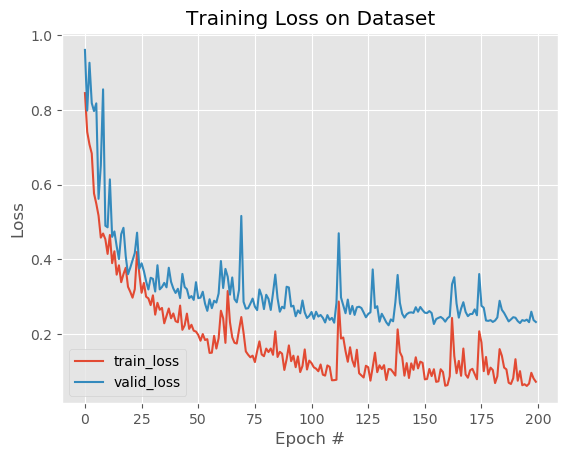

In [19]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["valid_loss"], label="valid_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [ ]:
def make_predictions(model, X, y):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		orig = X.copy()
		# find the filename and generate the path to ground truth
  
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = y.copy()
  
  
  		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(X, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
  
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
  
		# filter out the weak predictions and convert them to integers
		# predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)

		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

[INFO] load up model...


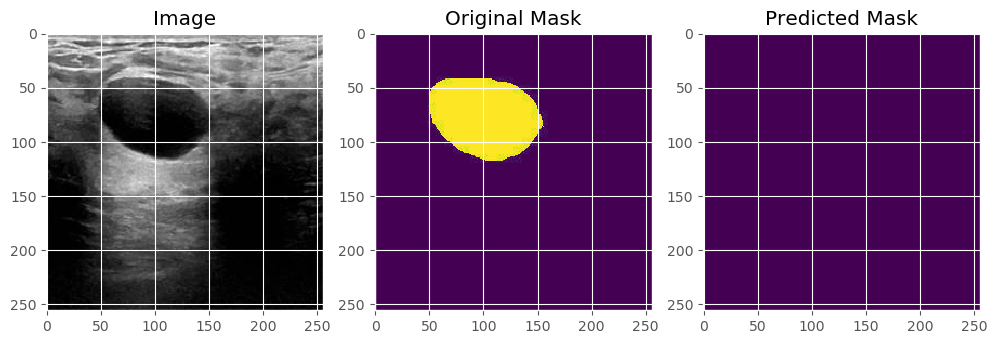

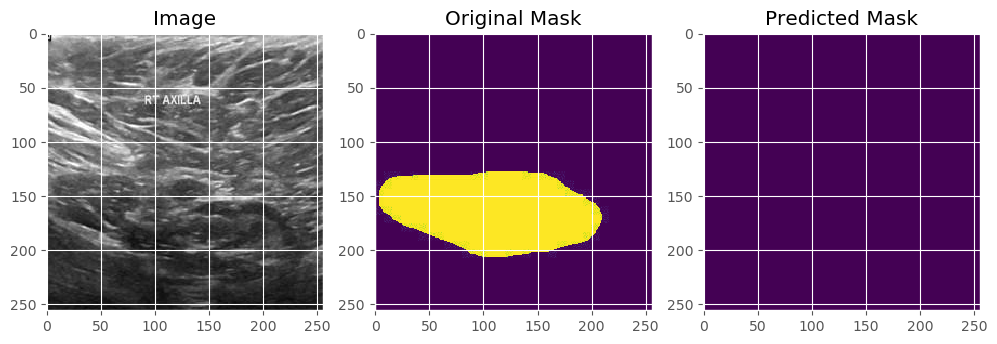

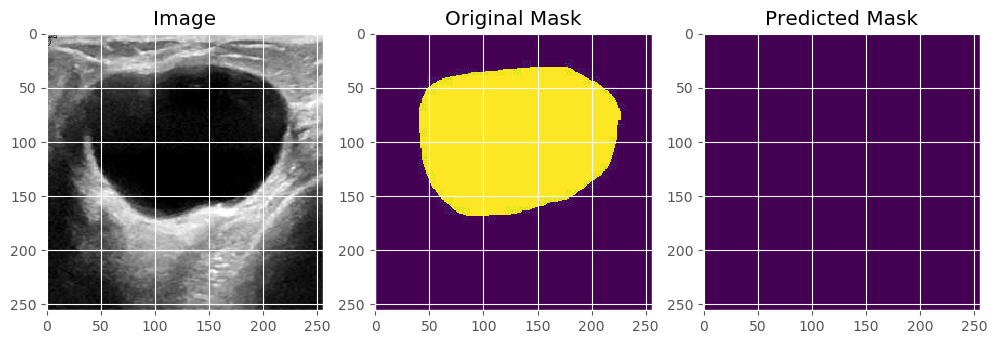

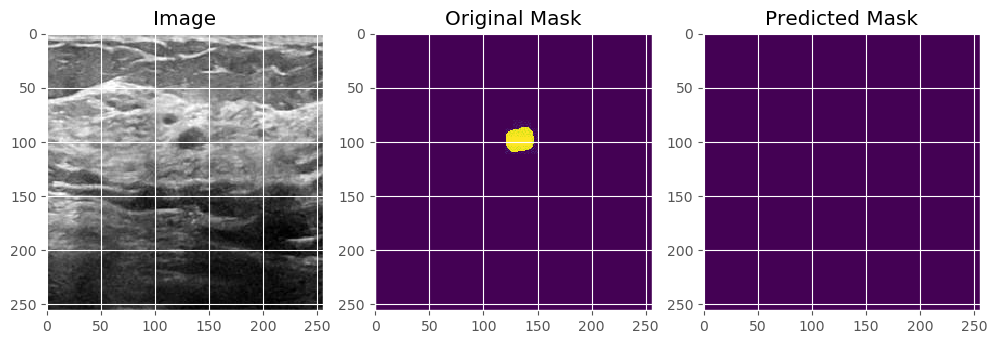

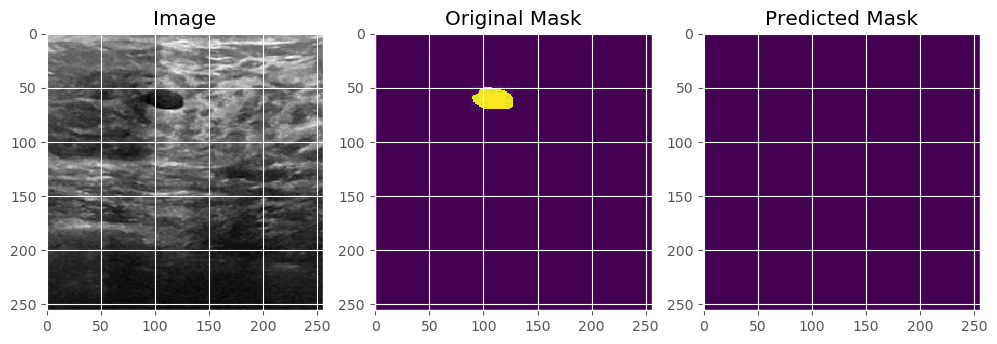

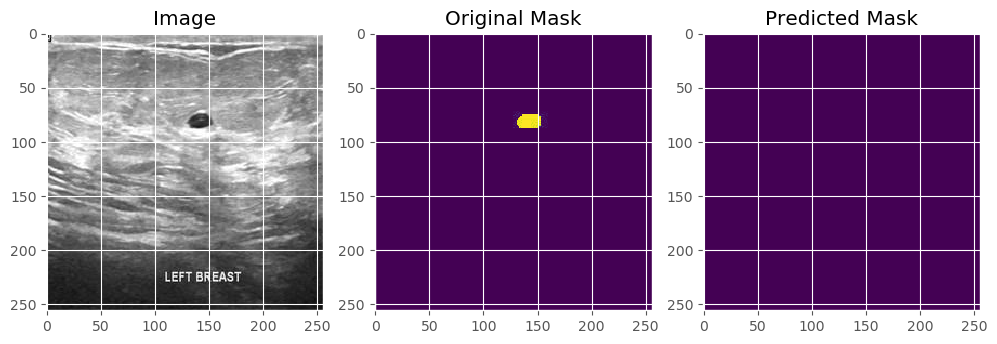

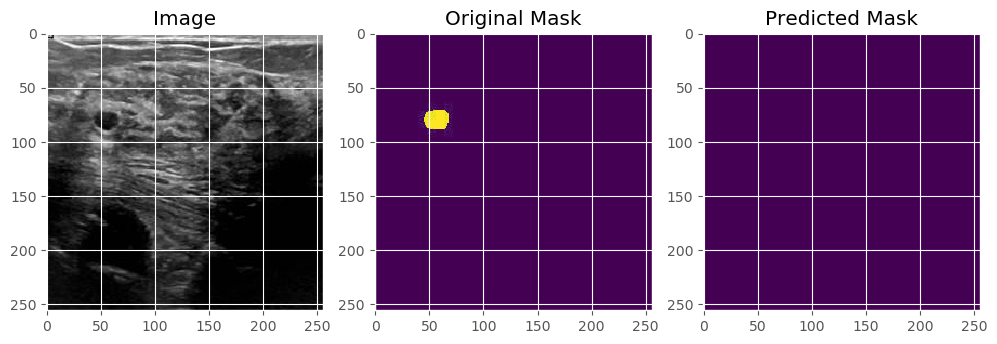

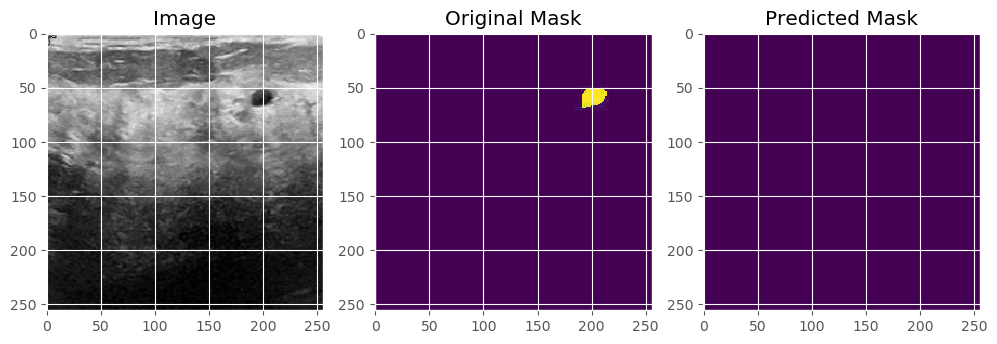

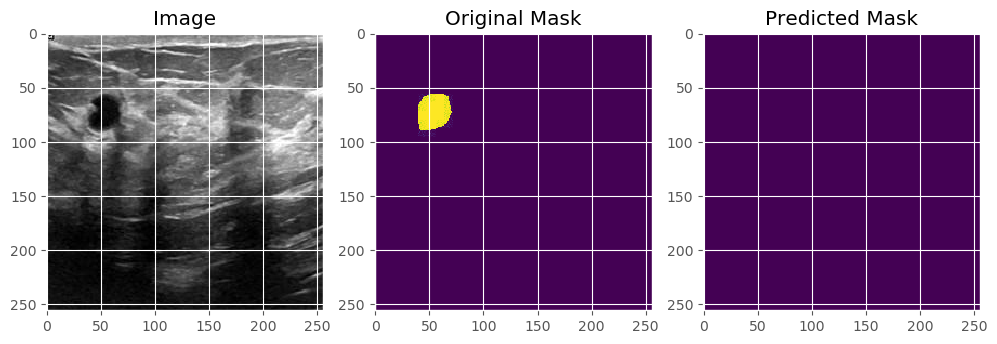

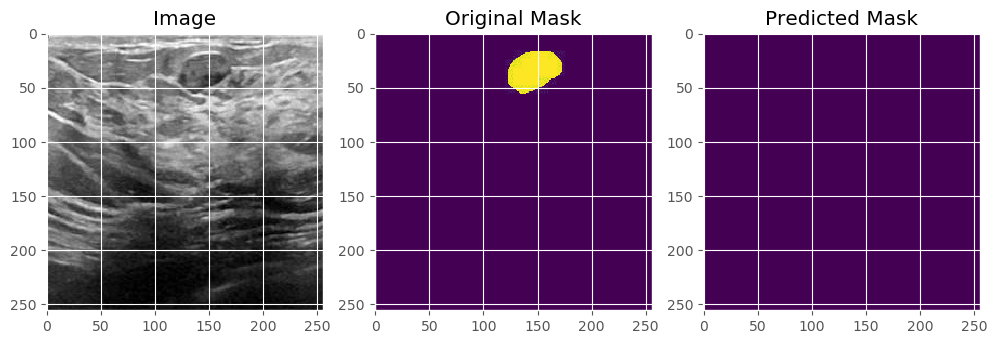

In [ ]:
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)

# iterate over the randomly selected test image paths
for i in range(10):
	# make predictions and visualize the results
	make_predictions(unet, X_train_npy[i], y_train_npy[i])